## **Clase para la construcción de la Segmentación RFM**

In [66]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [50]:
data = pd.read_csv("../../data/train.csv")

Debes renombrar las columnas que serán necesarias para el uso de la librería.
Debes identificar en las columnas del dataframe que hagan referencia a la identificación del consumidor, el día en que se ejecutó la venta del producto o el día en que se generó la fecha de orden, una columna de venta total (precio por cantidad) por registro, en el caso no se cuente la columna de venta total se debe generar una columna y, por último, elegir una columna que no tenga valores nulos, puede ser la columna de identificación del registro.

In [ ]:
data = data.rename(columns = {
    'Identificación del consumidor' : 'Customer ID',
    'Día en que se ejecutó la venta' : 'Date',
    'Venta Total' : 'Sales',
    'Identificación del registo' : 'Order ID'
})

In [51]:
data["Order Date"] = pd.to_datetime(data["Order Date"]).dt.strftime("%Y%m%d")
data = data.rename(columns = {'Order Date':'Date'})

In [103]:
class Segmentation:
    def __init__(self, dataframe, day:str, positions:list, rfm, segment):
        self.dataframe = dataframe
        self.day = day
        self.positions = positions
        self.rfm = rfm
        self.segment = segment
        
    def RFM(dataframe, day:str, positions:list):
        # Apply variable type transformation from string to datetime
        # The function a string like '20230628' with the format like 'yyyymmdd'.
        dataframe = dataframe.iloc[:, positions]
        
        if isinstance(dataframe, pd.DataFrame):
            day = datetime.strptime(day, "%Y%m%d")
            dataframe["Date"] = dataframe["Date"].apply(lambda x : datetime.strptime(x, "%Y%m%d"))
            rfm = dataframe.groupby('Customer ID').agg({
                'Date': lambda x : (day - x.max()).days,
                'Order ID': lambda x : len(x),
                'Sales': lambda x : x.sum()
            })
            rfm.columns = ["Recency", "Frequency", "Monetary"]
            
            rfm["R"] = pd.qcut(rfm["Recency"], 5, labels = [5,4,3,2,1])
            rfm["F"] = pd.qcut(rfm["Frequency"], 5, labels = [1,2,3,4,5])
            rfm["M"] = pd.qcut(rfm["Monetary"], 5, labels = [1,2,3,4,5])
            rfm["SCORE"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)
            
            def SEGMENTATION(row):
                if row["R"] >= 1 and row["R"] <= 2 and row["F"] >= 1 and row["F"] <= 2:
                    return 'Hibernating'
                elif row["R"] >= 1 and row["R"] <= 2 and row["F"] >= 3 and row["F"] <= 4:
                    return 'At Risk'
                elif row["R"] >= 1 and row["R"] <= 2 and row["F"] == 5:
                    return 'Can\'t looser'
                elif row["R"] >= 3 and row["F"] >= 1 and row["F"] <= 2:
                    return 'About to sleep'
                elif row["R"] == 3 and row["F"] == 3:
                    return 'Need attention'
                elif row["R"] >= 3 and row["R"] <= 4 and row["F"] >= 4 and row["F"] <= 5:
                    return 'Loyal customers'
                elif row["R"] == 4 and row["F"] == 1:
                    return 'Promising'
                elif row["R"] == 5 and row["F"] == 1:
                    return 'New customers'
                elif row["R"] >= 4 and row["R"] <= 5 and row["F"] >= 2 and row["F"] <= 3:
                    return 'Potential loyalists'
                elif row["R"] == 5 and row["F"] >= 4 and row["F"] <= 5:
                    return 'Champions'
            
            rfm["Segment"] = rfm["R"].astype(str) + rfm["F"].astype(str)
            rfm["R"] = rfm["R"].astype(int)
            rfm["F"] = rfm["F"].astype(int)
            rfm["Segment"] = rfm.apply(SEGMENTATION, axis = 1)
            
            return rfm
        else:
            print("Verificar que el input `dataframe` sea del tipo dataframe.")
    
    def RFMTable(rfm):
        return rfm.groupby("Segment").mean().sort_values("Monetary", ascending = False)
    
    def RFMAnalysis(rfm):
        dataplot = pd.DataFrame(rfm.groupby("Segment")["SCORE"].count()).apply(lambda x : round(x/len(rfm["SCORE"])*100,2)).sort_values(by = 
                    "SCORE", ascending = True).rename(columns = {'SCORE':'Clientes (%)'})
        fig, ax = plt.subplots(figsize = (8,6), dpi = 70)
        dataplot.plot(ax = ax, kind = 'barh', color = 'orange')
        ax.bar_label(ax.containers[0], fontsize = 12)
        for i in ['bottom', 'left']:
            ax.spines[i].set_color('black')
            ax.spines[i].set_linewidth(1.5) 
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        top_side = ax.spines["top"]
        top_side.set_visible(False)
        ax.set_axisbelow(True)
        ax.grid(color='gray', linewidth=1, axis='y', alpha=0.4)
        plt.xlabel('Porcentaje de clientes')
        plt.ylabel('Segmento RFM')
        plt.title("Porcentaje de clientes por segmento", size = 16)
        plt.show()
        
    def RFMFindClientsBySegment(rfm, segment):
        segments = rfm["Segment"].unique()
        if segment in segments:
            rfm = rfm.reset_index()
            rfm = rfm[rfm["Segment"] == segment]
            return rfm
        else:
            print(f'''
Por favor, inserta un segmento válido.
Teniendo en cuenta que los segmentos válidos son \n{",".join(segments)}.
            ''')
        

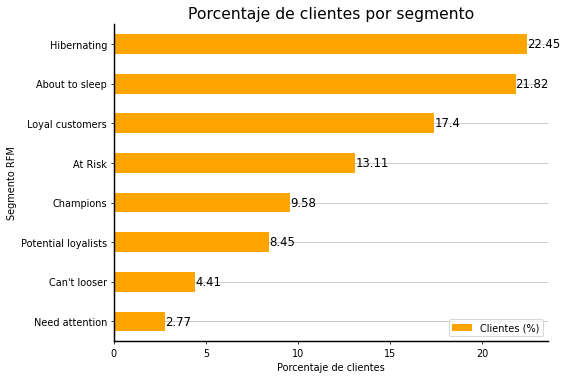


Por favor, inserta un segmento válido.
Teniendo en cuenta que los segmentos válidos son 
At Risk,Loyal customers,Can't looser,Hibernating,Potential loyalists,About to sleep,Champions,Need attention.
            


In [104]:
rfm = Segmentation.RFM(data, '20190115', positions = [1,2,5,17])
Segmentation.RFMTable(rfm)
Segmentation.RFMAnalysis(rfm)
Segmentation.RFMFindClientsBySegment(rfm, "Hola")